In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pickle

In [2]:
def loadDataset():
    path = '../../../DataSets/DevanagariHandwrittenCharacterDataset/Train/*'
    train_l = []
    train_d = [] # pixels 32*32
    for label ,folder_name in enumerate(glob.glob(path)):
        for image in (glob.glob(folder_name+'/*')):
            imgdata = plt.imread(image).ravel()  # return (1024,) array  
            train_d.append(imgdata)
            train_l.append(label)
    # takes 20 sec
    
    path = '../../../DataSets/DevanagariHandwrittenCharacterDataset/Test/*'
    test_l = []
    test_d = [] # pixels 32*32
    for label ,folder_name in enumerate(glob.glob(path)):
        for image in (glob.glob(folder_name+'/*')):
            imgdata = plt.imread(image).ravel()  # return (1024,) array  
            test_d.append(imgdata)
            test_l.append(label)
    # takes 10 sec

    return np.vstack(train_d) , np.vstack(test_d) , np.vstack(train_l) , np.vstack(test_l)

(78200, 1024)
(13800, 1024)
(78200, 1)
(13800, 1)


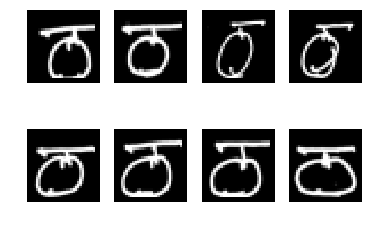

In [5]:
# takes approx. 30sec
X_train , X_test , y_train , y_test = loadDataset()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

for i in range(1,9):
    plt.subplot(240+i)
    plt.axis('off')
    plt.imshow(X_train[4581+i,:].reshape(32,32), cmap='gray')
plt.show()

In [6]:
class NeuralNetwork():
    
    def __init__(self):
        
        self.layers_n       = [] # no. of layers
        self.theta_layers   = [] # hidden layers weight list
        self.bias           = []
        self.v0             = [] # exponential weight for momentum it also works as a bias 
        self.vb             = [] # exponential bias
        self.activations    = [] # list of activations
        self.dL_dA          = [] # derivative w.r.t activations
        self.dL_dtheta      = [] # derivative w.r.t weights 
        self.dL_dbias       = [] # derivative w.r.t bias
        self.itera          = [] # store iterations
        self.csfun          = [] # store cost function values
                
    def add(self , neuron ):
        self.layers_n.append(neuron)
        
    def one_hot_label(self , y):
        one_hot_labels = np.zeros((y.shape[0] , self.layers_n[-1]))
        for i in range(y.shape[0]):  
            one_hot_labels[i, y[i] ] = 1
        return one_hot_labels
    
    def fit(self , X , y , batch_size = 128 , alpha = 0.01 , epoche = 100,lmda = .01):
        # He initialization
        for i in range(len(self.layers_n)-1): 
            self.theta_layers.append(np.random.randn(self.layers_n[i],self.layers_n[i+1]) * np.sqrt(2/self.layers_n[i]))
            self.v0.append(np.random.randn(self.layers_n[i],self.layers_n[i+1]) * np.sqrt(2/self.layers_n[i]))
            
            self.bias.append(np.random.randn(self.layers_n[i+1]) * np.sqrt(2/self.layers_n[i]) )
            self.vb.append(np.random.randn(self.layers_n[i+1]) * np.sqrt(2/self.layers_n[i]) )
        
        return self.gradientDecent( X , y , batch_size , alpha , epoche )
    
    def softmax(self , activation , theta , bias):
        exp = np.exp( np.dot( activation , theta ) + bias)
        denominator = np.sum( exp , axis = 1)
        s = list(map(lambda i : exp[:,i] / denominator , np.arange(self.layers_n[-1])))
        return np.array(s).T
    
    def relu(self,activation,theta, bias):
        q = (np.dot(activation , theta) + bias)
        return np.clip(q , a_min=0 , a_max = q)

    def forwardPropagation(self,X):
        
        self.activations    = []
        
        self.activations.append(X)
        for i in range(len(self.layers_n)-2):
            self.activations.append(self.relu(self.activations[i] , self.theta_layers[i] , self.bias[i]))
                      
        self.activations.append(self.softmax(self.activations[-1] , self.theta_layers[-1] , self.bias[-1]))
        
    def costFunction(self,X,y):
        
        self.y = self.one_hot_label(y)
        self.forwardPropagation(X)
        
        #np.nan_to_num(self.activations[-1] , copy = False)
        self.crossEntropy = self.y * np.log(self.activations[-1])
        #np.nan_to_num(self.crossEntropy, copy=False)
        
        #regu = self.lmda * (np.sum(self.theta_layer1)**2 + np.sum(self.theta_layer2)**2 + np.sum(self.theta_layer3)**2 + np.sum(self.theta_layer4)**2)
        return (1/X.shape[0] * -np.sum(self.crossEntropy)) #+ regu  # regu = 0 bcz lmda is zero 
      
    
    def backPropagation(self,X,y,alpha):
        
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        
        self.forwardPropagation(X)
        
        self.y_cap = self.activations[-1]
        self.target_y = self.one_hot_label(y)
        
        self.dL_dA.append(self.y_cap - self.target_y)
        
        for i in range(len(self.layers_n)-2):   
            
            self.dL_dA.append( np.dot( self.dL_dA[i] , self.theta_layers[-1-i].T ) )
        
        for i in range(len(self.layers_n)-1):  
            
            self.dL_dtheta.append(1/X.shape[0] * (np.dot(self.activations[-2-i].T , self.dL_dA[i]))) 
            self.dL_dbias.append(1/X.shape[0] * self.dL_dA[i])
        
        for i in range(len(self.layers_n)-1):  
            
            self.theta_layers[i]    -= (alpha * self.dL_dtheta[-1-i])  
            self.bias[-1-i]         -= (alpha * self.dL_dbias[i].sum(axis = 0))                  
            
            
    def gradientDecent(self , X , y , batch , alpha , epoche  ):
        i = 1
        while i < epoche:
            
            index = np.random.randint(0 , X.shape[0] , size=(batch,))
        
            initial_cost = self.costFunction(X[index] , y[index] )
       
            self.backPropagation(X[index], y[index],alpha )
                    
            print('Iteration {} Cost function {}'.format(i , initial_cost ))    
        
            self.itera.append(i)
            self.csfun.append(initial_cost)
            i+=1
            
        final_cost = self.costFunction(X[index] , y[index] )
        self.itera.append(i)
        self.csfun.append(final_cost)
            
        
            
    def gradient_plot(self):
        plt.plot(self.itera[10:],self.csfun[10:])
         
        
    def accuracy(self , X , y):
        self.forwardPropagation(X)
        pred = np.argmax(self.activations[-1],axis=1)
        c1 = 0
        for i,j in enumerate(y):
            if j == pred[i]:
                c1+=1
        print("Accuracy : ",(c1/y.shape[0])*100,'%')    


In [8]:
NN = NeuralNetwork()
NN.add(1024)
NN.add(46)
NN.fit(X_train , y_train , batch_size=128 , alpha = 0.01 ,  epoche=10 , lmda = 0.1)

Iteration 1 Cost function 3.9773824455787823
Iteration 2 Cost function 4.073333624030079
Iteration 3 Cost function 4.058463037704657
Iteration 4 Cost function 4.083383945995834
Iteration 5 Cost function 4.037293129530783
Iteration 6 Cost function 4.026803325860759
Iteration 7 Cost function 4.075951401803641
Iteration 8 Cost function 3.95867946966814
Iteration 9 Cost function 3.9909659346585906


In [82]:

import math

mini_batch_size = 20000

np.random.seed(0)          
m = X_train.shape[0]       
mini_batches = []
    
permutation = list(np.random.permutation(m))
shuffled_X = X_train[permutation,:]
shuffled_Y = y_train[permutation].reshape((m,1))

num_complete_minibatches = math.floor(m/mini_batch_size) 
num_complete_minibatches


for k in range(0, num_complete_minibatches):
    mini_batch_X = shuffled_X[k * mini_batch_size : (k + 1) * mini_batch_size, :]
    mini_batch_Y = shuffled_Y[k * mini_batch_size : (k + 1) * mini_batch_size, :]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)

if m % mini_batch_size != 0:
    mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size: , :]
    mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size: , :]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)
    

In [83]:
for x,y in mini_batches:
    print(x.shape , y.shape)

(20000, 1024) (20000, 1)
(20000, 1024) (20000, 1)
(20000, 1024) (20000, 1)
(18200, 1024) (18200, 1)
